In [ ]:
# Load drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from tifffile import *
from glob import glob
!pip install rasterio
!pip install earthpy
import rasterio
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from matplotlib.patches import Patch
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors

from matplotlib.colors import Normalize
from scipy.interpolate import interpn
import rasterio as rio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go

# Import libraries
import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interpn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from osgeo import gdal
import os
import glob
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report)


from scipy.ndimage.filters import generic_filter
from scipy.stats import mode

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import xgboost as xgb

# Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interpn
from google.colab import files

np.seterr(divide='ignore', invalid='ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-2-4f6808ef3848>:77: DeprecationWarning: Please use `generic_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import generic_filter


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
## Stack image with reference
with rasterio.open('/content/drive/MyDrive/GEE_composites/median_reflectance.tif') as src:
    reference = src.read()
reference = reference[-1,:,:]
reference.shape

(3783, 5389)

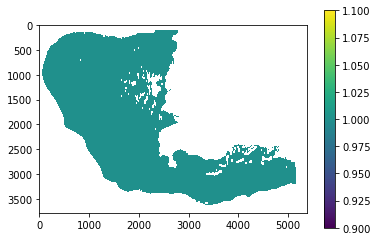

In [ ]:
## Stack image with reference
with rasterio.open('/content/drive/MyDrive/GEE_composites/median_reflectance.tif') as src:
    ref = src.read()

ref[-1,:,:][ref[-1,:,:] > 0] = 1
ref[-1,:,:][ref[-1,:,:] < 0] = 1
ref[-1,:,:][ref[-1,:,:] == 0] = 1
ref = ref[-1,:,:]

pc = plt.imshow(ref)
plt.colorbar(pc)

In [ ]:
def remove_nan(image):
    image = image.astype(np.float32) # from integer to float
    nan_mask = np.any(np.isnan(image), axis=0)
    image[:, nan_mask] = np.nan

    return image

In [ ]:
def clean_image(image):
    # Create a mask for the pixels where the last band is less than -20
    mask = image[:, :, 12] < -20
    image[mask, :] = np.nan
    return image

In [ ]:
def remove_patches_with_too_many_NaN(patches, threshold=0.9):
    # Create an array of the same shape as patches to store the mask
    mask = np.zeros(patches.shape, dtype=bool)
    # Find the indices of the NaN values in each patch
    nan_indices = np.isnan(patches)
    # Use the nan_indices to create the mask
    mask[nan_indices] = True
    # Calculate the fraction of NaN values in each patch
    fraction_NaN = np.mean(mask, axis=(1, 2, 3))
    # Keep only the patches with fewer than the threshold fraction of NaN values
    kept_patches = patches[fraction_NaN < threshold, :, :, :]
    # Get the indices of the removed patches
    removed_indices = np.where(fraction_NaN >= threshold)[0]
    return kept_patches, removed_indices

def set_NaN_to_zero(patches):
    # Replace the NaN values in each patch with 0
    patches[np.isnan(patches)] = 0
    return patches

import random

def extract_patches(image, patch_size, stride):
    # Calculate the number of patches in each dimension
    n_rows = (image.shape[0] - patch_size[0]) // stride + 1
    n_cols = (image.shape[1] - patch_size[1]) // stride + 1
    n_patches = n_rows * n_cols
    patches = np.zeros((n_patches, patch_size[0], patch_size[1], image.shape[2]))

    # Keep track of the indices of the patches that meet the size requirement
    valid_patch_indices = []

    # Loop over the patches and extract them using slicing
    patch_index = 0
    for i in range(0, image.shape[0] - patch_size[0] + 1, stride):
        for j in range(0, image.shape[1] - patch_size[1] + 1, stride):
            if i <= image.shape[0] - patch_size[0] and j <= image.shape[1] - patch_size[1]:
                i_rand = random.randint(0, patch_size[0]-1)
                j_rand = random.randint(0, patch_size[1]-1)
                patch = image[i+i_rand:i + i_rand + patch_size[0], j+j_rand:j + j_rand + patch_size[1], :]
                if patch.shape == (patch_size[0], patch_size[1], image.shape[2]):
                    patches[patch_index, :, :, :] = patch
                    valid_patch_indices.append(patch_index)
                    patch_index += 1

    # Only return the patches that meet the size requirement
    return patches[valid_patch_indices, :, :, :]

def extract_zeroed_patches(image_train, image_test, patch_size=(64, 64, 13), nan_threshold=0.9):
    # Extract the patches for train area
    patches_train = extract_patches(image_train, patch_size, stride)
    print('Number of patches for training:', patches_train.shape[0])
    print('Patch shape:', patches_train.shape[1:])
    # Remove patches with more than `nan_threshold` NaN values
    kept_patches_train, removed_indices = remove_patches_with_too_many_NaN(patches_train, threshold=nan_threshold)
    print(kept_patches_train.shape)
    # Set the NaN values in the kept patches to 0
    zeroed_patches_train = set_NaN_to_zero(kept_patches_train)
    print(zeroed_patches_train.shape)

    # Extract the patches for test area
    patches_test = extract_patches(image_test, patch_size, stride)
    print('Number of patches for testing:', patches_test.shape[0])
    print('Patch shape:', patches_test.shape[1:])
    # Remove patches with more than `nan_threshold` NaN values
    kept_patches_test, removed_indices = remove_patches_with_too_many_NaN(patches_test, threshold=nan_threshold)
    print(kept_patches_test.shape)
    # Set the NaN values in the kept patches to 0
    zeroed_patches_test = set_NaN_to_zero(kept_patches_test)
    print(zeroed_patches_test.shape)

    return zeroed_patches_train, zeroed_patches_test, removed_indices

In [ ]:
import tensorflow as tf

def split_data(zeroed_patches_train, zeroed_patches_test, patch_size, val_prop=0.25):
    # Split the zeroed_patches array into inputs and targets
    X_train = zeroed_patches_train[:, :, :, :-1]
    y_train = zeroed_patches_train[:, :, :, -1]
    y_train = tf.reshape(y_train, (-1, patch_size[0], patch_size[1], 1))

    X_test = zeroed_patches_test[:, :, :, :-1]
    y_test = zeroed_patches_test[:, :, :, -1]
    y_test = tf.reshape(y_test, (-1, patch_size[0], patch_size[1], 1))

    # Calculate the number of samples in the validation set
    val_samples = int(X_train.shape[0] * val_prop)

    # Split the training data into training and validation sets
    X_val = X_train[-val_samples:, :, :, :]
    y_val = y_train[-val_samples:, :, :, :]
    X_train = X_train[:-val_samples, :, :, :]
    y_train = y_train[:-val_samples, :, :, :]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def masked_rmse(y_true, y_pred):
    # Create a mask of non-NaN and non-zero values
    mask = tf.math.logical_and(~tf.math.is_nan(y_true), y_true != 0)

    # Apply the mask to both y_true and y_pred
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    # Calculate the RMSE between non-NaN, non-zero elements
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    rmse = tf.math.sqrt(mse)

    return rmse

In [ ]:
import random

def train_model(X_train, y_train, X_val, y_val, X_test, model):
    # Set random seed for NumPy
    np.random.seed(1)
    # Set random seed for Python's built-in random module
    random.seed(1)
    # Set random seed for TensorFlow
    tf.random.set_seed(1)

    keras.backend.clear_session()

    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=masked_rmse)

    # Train the model on the training data
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model on the testing data
    predictions = model.predict(X_test)
    print(predictions.shape)
    return history, predictions

In [ ]:
#### NOT RANDOM ####

def extract_patches(image, patch_size, stride):
    # Calculate the number of patches in each dimension
    n_rows = (image.shape[0] - patch_size[0]) // stride + 1
    n_cols = (image.shape[1] - patch_size[1]) // stride + 1
    n_patches = n_rows * n_cols
    patches = np.zeros((n_patches, patch_size[0], patch_size[1], image.shape[2]))

    # Keep track of the indices of the patches that meet the size requirement
    valid_patch_indices = []

    # Loop over the patches and extract them using slicing
    patch_index = 0
    for i in range(0, image.shape[0] - patch_size[0] + 1, stride):
        for j in range(0, image.shape[1] - patch_size[1] + 1, stride):
            if i <= image.shape[0] - patch_size[0] and j <= image.shape[1] - patch_size[1]:
                i_rand = random.randint(0, patch_size[0]-1)
                j_rand = random.randint(0, patch_size[1]-1)
                patch = image[i+i_rand:i + i_rand + patch_size[0], j+j_rand:j + j_rand + patch_size[1], :]
                if patch.shape == (patch_size[0], patch_size[1], image.shape[2]):
                    patches[patch_index, :, :, :] = patch
                    valid_patch_indices.append(patch_index)
                    patch_index += 1

    # Only return the patches that meet the size requirement
    return patches[valid_patch_indices, :, :, :]


In [ ]:
# BEST
# Define the model architecture
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(16,16,12)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(1, (1, 1), padding='same', activation='linear')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        3488      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn import metrics

def evaluate_model(predictions, y_test):
    predictions = np.array(predictions)
    y_test = np.array(y_test)

    # Calculate the RMSE
    rmse = np.sqrt(np.nanmean((predictions - y_test) ** 2))
    print('RMSE:', rmse)

    y_test_flat = y_test.flatten()
    predictions_flat = predictions.flatten()
    df_pred = pd.DataFrame(predictions_flat)
    df_test = pd.DataFrame(y_test_flat)
    df = pd.concat([df_test, df_pred], axis =1)
    df2 = df.dropna() # Remove NaN values
    df2.columns = ['Reference','Predicted']
    df2= df2[df2['Reference'] < 0] # set max ref depth
    df2= df2[df2['Predicted'] > -50] # set max ref depth
    df2= df2[df2['Predicted'] < 0] # set max ref depth

    #df2= df2[df2['Reference'] > -10] # set max ref depth
    #df2 = df2.dropna() # Remove NaN values
    df3 = df2.reset_index(drop=True)
    df3['Error'] = df3['Predicted'] - df3['Reference']

    # Metrics
    rmse = mean_squared_error(df3.Reference, df3.Predicted, squared=False)
    r2 = metrics.r2_score(df3.Reference, df3.Predicted)
    mae = np.mean(abs(df3.Reference - df3.Predicted))
    return df3, mae, rmse, r2


In [ ]:
def reshape_predictions(predictions, image, patch_size, removed_indices):
    # Get the shape of the original test area image
    test_area_shape = image.shape

    # Create a new array with the same shape as the test area image, filled with NaN values
    reconstructed_test_area = np.full(test_area_shape, np.nan)

    # Calculate the number of patches in each dimension
    n_rows = (test_area_shape[0] - patch_size[0]) // patch_size[0] + 1
    n_cols = (test_area_shape[1] - patch_size[1]) // patch_size[1] + 1

    # Create a mask with True values for the removed patches
    removed_mask = np.zeros((n_rows, n_cols), dtype=bool)
    removed_mask[np.unravel_index(removed_indices, (n_rows, n_cols))] = True

    # Loop over the patches and fill in the corresponding elements in the reconstructed test area
    patch_index = 0
    for i in range(0, test_area_shape[0] - patch_size[0] + 1, patch_size[0]):
        for j in range(0, test_area_shape[1] - patch_size[1] + 1, patch_size[1]):
            if not removed_mask[i // patch_size[0], j // patch_size[1]]:
                # If the patch was not removed, use the corresponding patch from predictions
                patch = predictions[patch_index, :, :, :]
                reconstructed_test_area[i:i + patch_size[0], j:j + patch_size[1], :] = patch
                patch_index += 1
            else:
                # If the patch was removed, fill in the corresponding region with NaNs
                reconstructed_test_area[i:i + patch_size[0], j:j + patch_size[1], :] = np.nan

    return reconstructed_test_area

In [ ]:
def concat_ref_images(image_1, image_2, image_3, image_4):
    ref_image_1 = image_1[:,:,-1]
    ref_image_2 = image_2[:,:,-1]
    ref_image_3 = image_3[:,:,-1]
    ref_image_4 = image_4[:,:,-1]

    ref_1_2 = np.concatenate((ref_image_1, ref_image_2), axis = 0)

    ref_image_4_pad = np.pad(ref_image_4, [(0,0), (0,211)], 'constant', constant_values=(np.nan,))
    ref_3_4 = np.concatenate((ref_image_3, ref_image_4_pad), axis = 1)
    ref_3_4 = np.pad(ref_3_4, [(0,147), (0,0)], 'constant', constant_values=(np.nan,))
    ref_3_4 = ref_3_4[:,0:5389]

    ref_all = np.concatenate((ref_1_2, ref_3_4), axis = 0)

    return ref_all

In [ ]:
def reshape_all_predictions(pred_image_1, pred_image_2, pred_image_3, pred_image_4, ref_all):
    pred_image_1 = pred_image_1[:,:,-1]
    pred_image_2 = pred_image_2[:,:,-1]
    pred_image_3 = pred_image_3[:,:,-1]
    pred_image_4 = pred_image_4[:,:,-1]
    y_pred_1_2 = np.concatenate((pred_image_1, pred_image_2), axis = 0)
    pred_image_4_pad = np.pad(pred_image_4, [(0,0), (0,211)], 'constant', constant_values=(np.nan,))
    y_pred_3_4 = np.concatenate((pred_image_3, pred_image_4_pad), axis = 1)
    y_pred_3_4 = np.pad(y_pred_3_4, [(0,147), (0,0)], 'constant', constant_values=(np.nan,))
    y_pred_3_4 = y_pred_3_4[:,0:5389]
    y_pred_all = np.concatenate((y_pred_1_2, y_pred_3_4), axis = 0)
    y_pred_mask = y_pred_all.copy()
    y_pred_mask[y_pred_mask <= 0] = 1
    ref_all_masked = ref_all * y_pred_mask
    ref_mask = ref_all_masked.copy()
    ref_mask[ref_mask <= 0] = 1
    y_pred_all_masked = y_pred_all * ref_mask
    return y_pred_all_masked, ref_all_masked

In [ ]:
def stack_layers(image, ref, reference):
    image = image.astype(np.float32) # from integer to float
    image = np.where(image == 0, np.nan, image)
    image = np.where(image < 0, np.nan, image)
    image = np.concatenate((image, reference[np.newaxis,:,:]), axis=0)

    image_copy = np.isnan(image).any(axis=0)
    image_copy = np.where(image_copy, np.nan, 1)
    image = image * image_copy
    #image = np.moveaxis(image, 0, -1)
    return image

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def normalize_image(image):

    # extract non-NaN values from the input image
    image_no_nan = image[~np.isnan(image).any(axis=2)]
    # Only normalize non reference data
    no_ref = image_no_nan[:,:-1]

    # Get reference data
    ref = image_no_nan[:,-1]

    # Use std scaler for bands. not for reference data
    scaler = StandardScaler().fit(no_ref)
    no_ref_z = scaler.transform(no_ref)

    # Stack satellite data and reference data
    image_z = np.column_stack((no_ref_z, ref))
    shape = image_z.shape[0]
    print('shape: ',shape)
    no_nan = image_z.reshape(shape*13)
    nan_mask = np.isnan(image)

    image_z = np.empty_like(image)
    image_z.fill(np.nan) # fill empty image with NaN
    image_z[~nan_mask] = no_nan

    return image_z


In [ ]:
import numpy as np
import random

def extract_patches(image, patch_size, stride, random_start=True):
    # Calculate the number of patches in each dimension
    n_rows = (image.shape[0] - patch_size[0]) // stride + 1
    n_cols = (image.shape[1] - patch_size[1]) // stride + 1
    n_patches = n_rows * n_cols
    patches = np.zeros((n_patches, patch_size[0], patch_size[1], image.shape[2]))

    # Loop over the patches and extract them using slicing
    patch_index = 0

    if random_start:
        start_row = random.randint(0, 33)  # Random start point between row 0 and 32
        start_col = random.randint(0, 33)  # Random start point between column 0 and 32
    else:
        start_row, start_col = 0, 0

    for i in range(start_row, image.shape[0] - patch_size[0] + 1, stride):
        for j in range(start_col, image.shape[1] - patch_size[1] + 1, stride):
            patch = image[i:i + patch_size[0], j:j + patch_size[1], :]
            patches[patch_index, :, :, :] = patch
            patch_index += 1

    return patches



# Patches 64x64 with max depth 20m. Area 1

## Patches 2019

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2019 = []
patches_train_2019 = []


root_dir = '/content/drive/MyDrive/GEE_good_2019/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 1
      # Select training area:
      image_no_1 = np.copy(image)
      # Set pixels in specified slice to NaN
      image_no_1[70:1035,:, :] = np.nan
      # Train set
      image_1 = image[70:1035,:, :]
      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_1, image_1, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2019.append(zeroed_patches_test)
      patches_train_2019.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2018-12-19
shape:  5507532
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1623, 64, 64, 13)
(1623, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(413, 64, 64, 13)
(413, 64, 64, 13)
2019-01-03
shape:  5757403
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1651, 64, 64, 13)
(1651, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(415, 64, 64, 13)
(415, 64, 64, 13)
2019-01-08
shape:  5776356
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1737, 64, 64, 13)
(1737, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(412, 64, 64, 13)
(412, 64, 64, 13)
2019-01-13
shape:  5688645
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1740, 64, 64, 13)
(1740, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(402, 64, 64, 13)
(402, 64, 64, 13)
2019-02-02
shape:  5723961
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1724,

In [ ]:
patches_test_2019_array = np.concatenate(patches_test_2019, axis=0)
patches_test_2019_array.shape
# With no random starting point and no 10% striding: 5100 patches.

(6170, 64, 64, 13)

In [ ]:
patches_train_2019_array = np.concatenate(patches_train_2019, axis=0)
patches_train_2019_array.shape
# With no random starting point and no 10% striding: 20081 patches.

(25494, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_1_2019_v2.npy', patches_test_2019_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_1_2019_v2.npy', patches_train_2019_array)

## Patches 2020

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2020 = []
patches_train_2020 = []


root_dir = '/content/drive/MyDrive/GEE_good_2020/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 1
      # Select training area:
      image_no_1 = np.copy(image)
      # Set pixels in specified slice to NaN
      image_no_1[70:1035,:, :] = np.nan
      # Train set
      image_1 = image[70:1035,:, :]
      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_1, image_1, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2020.append(zeroed_patches_test)
      patches_train_2020.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2020-02-02
shape:  5769434
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1743, 64, 64, 13)
(1743, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(405, 64, 64, 13)
(405, 64, 64, 13)
2020-02-12
shape:  5496404
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1647, 64, 64, 13)
(1647, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(385, 64, 64, 13)
(385, 64, 64, 13)
2020-02-17
shape:  5762866
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1734, 64, 64, 13)
(1734, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(486, 64, 64, 13)
(486, 64, 64, 13)
2020-03-13
shape:  5607266
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1717, 64, 64, 13)
(1717, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(412, 64, 64, 13)
(412, 64, 64, 13)
2020-10-09
shape:  5690770
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1745,

In [ ]:
patches_test_2020_array = np.concatenate(patches_test_2020, axis=0)
patches_test_2020_array.shape

(4638, 64, 64, 13)

In [ ]:
patches_train_2020_array = np.concatenate(patches_train_2020, axis=0)
patches_train_2020_array.shape
# With no random starting point and no 10% striding: 14797 patches.

(18876, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_1_2020_v2.npy', patches_test_2020_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_1_2020_v2.npy', patches_train_2020_array)

## Patches 2021

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2021 = []
patches_train_2021 = []


root_dir = '/content/drive/MyDrive/GEE_good_2021/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 1
      # Select training area:
      image_no_1 = np.copy(image)
      # Set pixels in specified slice to NaN
      image_no_1[70:1035,:, :] = np.nan
      # Train set
      image_1 = image[70:1035,:, :]
      # Extract patches
      patch_size = (16, 16, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_1, image_1, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2021.append(zeroed_patches_test)
      patches_train_2021.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2021-01-07
shape:  5773538
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1736, 64, 64, 13)
(1736, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(414, 64, 64, 13)
(414, 64, 64, 13)
2021-01-12
shape:  5772530
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1749, 64, 64, 13)
(1749, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(411, 64, 64, 13)
(411, 64, 64, 13)
2021-01-17
shape:  5641571
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1734, 64, 64, 13)
(1734, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(409, 64, 64, 13)
(409, 64, 64, 13)
2021-01-22
shape:  5776372
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1742, 64, 64, 13)
(1742, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(414, 64, 64, 13)
(414, 64, 64, 13)
2021-01-27
shape:  5777107
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1745,

In [ ]:
patches_test_2021_array = np.concatenate(patches_test_2021, axis=0)
patches_test_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.

(5829, 64, 64, 13)

In [ ]:
patches_train_2021_array = np.concatenate(patches_train_2021, axis=0)
patches_train_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.
# With random patching, no norm: 23056 patches.

(23945, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_1_2021_v2.npy', patches_test_2021_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_1_2021_v2.npy', patches_train_2021_array)

## Patches 2022

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2022 = []
patches_train_2022 = []


root_dir = '/content/drive/MyDrive/GEE_good_2022/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 1
      # Select training area:
      image_no_1 = np.copy(image)
      # Set pixels in specified slice to NaN
      image_no_1[70:1035,:, :] = np.nan
      # Train set
      image_1 = image[70:1035,:, :]
      # Extract patches
      patch_size = (16, 16, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_1, image_1, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2022.append(zeroed_patches_test)
      patches_train_2022.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2022-01-12
shape:  5776609
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1654, 64, 64, 13)
(1654, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(412, 64, 64, 13)
(412, 64, 64, 13)
2022-01-22
shape:  5657143
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1713, 64, 64, 13)
(1713, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(414, 64, 64, 13)
(414, 64, 64, 13)
2022-02-21
shape:  3293632
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1480, 64, 64, 13)
(1480, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(328, 64, 64, 13)
(328, 64, 64, 13)
2022-03-03
shape:  1391391
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(302, 64, 64, 13)
(302, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(391, 64, 64, 13)
(391, 64, 64, 13)
2022-11-03
shape:  3021039
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1403, 6

In [ ]:
patches_test_2022_array = np.concatenate(patches_test_2022, axis=0)
patches_test_2022_array.shape
# With no random starting point and no 10% striding: 2729 patches.

(2790, 64, 64, 13)

In [ ]:
patches_train_2022_array = np.concatenate(patches_train_2022, axis=0)
patches_train_2022_array.shape
# With no random starting point and no 10% striding: 10335 patches.

(13285, 64, 64, 13)

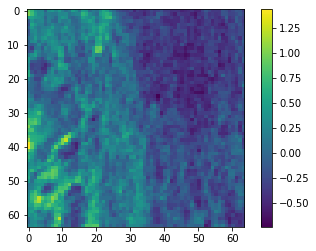

In [ ]:
plt.imshow(patches_train_2022_array[213,:,:,1])
plt.colorbar()
plt.show()


In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_1_2022_v2.npy', patches_test_2022_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_1_2022_v2.npy', patches_train_2022_array)

# Patches 64x64 with max depth 20m. Area 2

## Patches 2019

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2019 = []
patches_train_2019 = []


root_dir = '/content/drive/MyDrive/GEE_good_2019/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 2
      print('\n image 2:')
      image_no_2 = np.copy(image)
      image_no_2[1035:2000,:,:] = np.nan
      image_2 = image[1035:2000,:,:]

      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_2, image_2, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2019.append(zeroed_patches_test)
      patches_train_2019.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2018-12-19
shape:  5507532

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1743, 64, 64, 13)
(1743, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(369, 64, 64, 13)
(369, 64, 64, 13)
2019-01-03
shape:  5757403

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1758, 64, 64, 13)
(1758, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(402, 64, 64, 13)
(402, 64, 64, 13)
2019-01-08
shape:  5776356

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1748, 64, 64, 13)
(1748, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(399, 64, 64, 13)
(399, 64, 64, 13)
2019-01-13
shape:  5688645

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1659, 64, 64, 13)
(1659, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(400, 64, 64, 13)
(400, 64, 64, 13)
2019-02-02
shape:  5723961

 image 2:
Number of patc

In [ ]:
patches_test_2019_array = np.concatenate(patches_test_2019, axis=0)
patches_test_2019_array.shape
# With no random starting point and no 10% striding: 5100 patches.

(5952, 64, 64, 13)

In [ ]:
patches_train_2019_array = np.concatenate(patches_train_2019, axis=0)
patches_train_2019_array.shape
# With no random starting point and no 10% striding: 20081 patches.

(25864, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_2_2019_v2.npy', patches_test_2019_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_2_2019_v2.npy', patches_train_2019_array)

## Patches 2020

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2020 = []
patches_train_2020 = []


root_dir = '/content/drive/MyDrive/GEE_good_2020/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 2
      print('\n image 2:')
      image_no_2 = np.copy(image)
      image_no_2[1035:2000,:,:] = np.nan
      image_2 = image[1035:2000,:,:]
      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_2, image_2, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2020.append(zeroed_patches_test)
      patches_train_2020.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2020-02-02
shape:  5769434

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1754, 64, 64, 13)
(1754, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(396, 64, 64, 13)
(396, 64, 64, 13)
2020-02-12
shape:  5496404

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1723, 64, 64, 13)
(1723, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(402, 64, 64, 13)
(402, 64, 64, 13)
2020-02-17
shape:  5762866

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1759, 64, 64, 13)
(1759, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(403, 64, 64, 13)
(403, 64, 64, 13)
2020-03-13
shape:  5607266

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1750, 64, 64, 13)
(1750, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(376, 64, 64, 13)
(376, 64, 64, 13)
2020-10-09
shape:  5690770

 image 2:
Number of patc

In [ ]:
patches_test_2020_array = np.concatenate(patches_test_2020, axis=0)
patches_test_2020_array.shape

(4357, 64, 64, 13)

In [ ]:
patches_train_2020_array = np.concatenate(patches_train_2020, axis=0)
patches_train_2020_array.shape
# With no random starting point and no 10% striding: 14797 patches.

(19108, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_2_2020_v2.npy', patches_test_2020_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_2_2020_v2.npy', patches_train_2020_array)

## Patches 2021

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2021 = []
patches_train_2021 = []


root_dir = '/content/drive/MyDrive/GEE_good_2021/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 2
      print('\n image 2:')
      image_no_2 = np.copy(image)
      image_no_2[1035:2000,:,:] = np.nan
      image_2 = image[1035:2000,:,:]
      # Extract patches
      patch_size = (16, 16, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_2, image_2, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2021.append(zeroed_patches_test)
      patches_train_2021.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2021-01-07
shape:  5773538

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1666, 64, 64, 13)
(1666, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(402, 64, 64, 13)
(402, 64, 64, 13)
2021-01-12
shape:  5772530

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1755, 64, 64, 13)
(1755, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(399, 64, 64, 13)
(399, 64, 64, 13)
2021-01-17
shape:  5641571

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1774, 64, 64, 13)
(1774, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(391, 64, 64, 13)
(391, 64, 64, 13)
2021-01-22
shape:  5776372

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1756, 64, 64, 13)
(1756, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(399, 64, 64, 13)
(399, 64, 64, 13)
2021-01-27
shape:  5777107

 image 2:
Number of patc

In [ ]:
patches_test_2021_array = np.concatenate(patches_test_2021, axis=0)
patches_test_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.

(5557, 64, 64, 13)

In [ ]:
patches_train_2021_array = np.concatenate(patches_train_2021, axis=0)
patches_train_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.
# With random patching, no norm: 23056 patches.

(23942, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_2_2021_v2.npy', patches_test_2021_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_2_2021_v2.npy', patches_train_2021_array)

## Patches 2022

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2022 = []
patches_train_2022 = []


root_dir = '/content/drive/MyDrive/GEE_good_2022/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 2
      print('\n image 2:')
      image_no_2 = np.copy(image)
      image_no_2[1035:2000,:,:] = np.nan
      image_2 = image[1035:2000,:,:]
      # Extract patches
      patch_size = (16, 16, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_2, image_2, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2022.append(zeroed_patches_test)
      patches_train_2022.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2022-01-12
shape:  5776609

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1752, 64, 64, 13)
(1752, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(396, 64, 64, 13)
(396, 64, 64, 13)
2022-01-22
shape:  5657143

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1753, 64, 64, 13)
(1753, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(396, 64, 64, 13)
(396, 64, 64, 13)
2022-02-21
shape:  3293632

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1409, 64, 64, 13)
(1409, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(309, 64, 64, 13)
(309, 64, 64, 13)
2022-03-03
shape:  1391391

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(659, 64, 64, 13)
(659, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(122, 64, 64, 13)
(122, 64, 64, 13)
2022-11-03
shape:  3021039

 image 2:
Number of patche

In [ ]:
patches_test_2022_array = np.concatenate(patches_test_2022, axis=0)
patches_test_2022_array.shape
# With no random starting point and no 10% striding: 2729 patches.

(2839, 64, 64, 13)

In [ ]:
patches_train_2022_array = np.concatenate(patches_train_2022, axis=0)
patches_train_2022_array.shape
# With no random starting point and no 10% striding: 10335 patches.

(13407, 64, 64, 13)

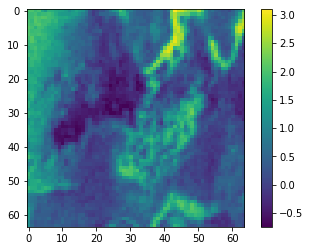

In [ ]:
plt.imshow(patches_train_2022_array[213,:,:,1])
plt.colorbar()
plt.show()


In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_2_2022_v2.npy', patches_test_2022_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_2_2022_v2.npy', patches_train_2022_array)

# Patches 64x64 with max depth 20m. Area 3

## Patches 2019

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2019 = []
patches_train_2019 = []


root_dir = '/content/drive/MyDrive/GEE_good_2019/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 3
      print('\n image 3:')
      image_no_3 = np.copy(image)
      image_no_3[2000:,:2800,:] = np.nan
      image_3 = image[2000:,:2800,:]

      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_3, image_3, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2019.append(zeroed_patches_test)
      patches_train_2019.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2018-12-19
shape:  5507532

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1500, 64, 64, 13)
(1500, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(627, 64, 64, 13)
(627, 64, 64, 13)
2019-01-03
shape:  5757403

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1517, 64, 64, 13)
(1517, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(616, 64, 64, 13)
(616, 64, 64, 13)
2019-01-08
shape:  5776356

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1559, 64, 64, 13)
(1559, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(644, 64, 64, 13)
(644, 64, 64, 13)
2019-01-13
shape:  5688645

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1467, 64, 64, 13)
(1467, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(631, 64, 64, 13)
(631, 64, 64, 13)
2019-02-02
shape:  5723961

 image 3:
Number of patc

In [ ]:
patches_test_2019_array = np.concatenate(patches_test_2019, axis=0)
patches_test_2019_array.shape
# With no random starting point and no 10% striding: 5100 patches.

(9444, 64, 64, 13)

In [ ]:
patches_train_2019_array = np.concatenate(patches_train_2019, axis=0)
patches_train_2019_array.shape
# With no random starting point and no 10% striding: 20081 patches.

(22728, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_3_2019_v2.npy', patches_test_2019_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_3_2019_v2.npy', patches_train_2019_array)

## Patches 2020

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2020 = []
patches_train_2020 = []


root_dir = '/content/drive/MyDrive/GEE_good_2020/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 3
      print('\n image 3:')
      image_no_3 = np.copy(image)
      image_no_3[2000:,:2800,:] = np.nan
      image_3 = image[2000:,:2800,:]

      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_3, image_3, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2020.append(zeroed_patches_test)
      patches_train_2020.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2020-02-02
shape:  5769434

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1556, 64, 64, 13)
(1556, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(646, 64, 64, 13)
(646, 64, 64, 13)
2020-02-12
shape:  5496404

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1540, 64, 64, 13)
(1540, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(618, 64, 64, 13)
(618, 64, 64, 13)
2020-02-17
shape:  5762866

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1518, 64, 64, 13)
(1518, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(624, 64, 64, 13)
(624, 64, 64, 13)
2020-03-13
shape:  5607266

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1497, 64, 64, 13)
(1497, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(618, 64, 64, 13)
(618, 64, 64, 13)
2020-10-09
shape:  5690770

 image 3:
Number of patc

In [ ]:
patches_test_2020_array = np.concatenate(patches_test_2020, axis=0)
patches_test_2020_array.shape

(6913, 64, 64, 13)

In [ ]:
patches_train_2020_array = np.concatenate(patches_train_2020, axis=0)
patches_train_2020_array.shape
# With no random starting point and no 10% striding: 14797 patches.

(16726, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_3_2020_v2.npy', patches_test_2020_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_3_2020_v2.npy', patches_train_2020_array)

## Patches 2021

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2021 = []
patches_train_2021 = []


root_dir = '/content/drive/MyDrive/GEE_good_2021/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 3
      print('\n image 3:')
      image_no_3 = np.copy(image)
      image_no_3[2000:,:2800,:] = np.nan
      image_3 = image[2000:,:2800,:]

      # Extract patches
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_3, image_3, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2021.append(zeroed_patches_test)
      patches_train_2021.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2021-01-07
shape:  5773538

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1547, 64, 64, 13)
(1547, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(611, 64, 64, 13)
(611, 64, 64, 13)
2021-01-12
shape:  5772530

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1559, 64, 64, 13)
(1559, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(639, 64, 64, 13)
(639, 64, 64, 13)
2021-01-17
shape:  5641571

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1459, 64, 64, 13)
(1459, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(634, 64, 64, 13)
(634, 64, 64, 13)
2021-01-22
shape:  5776372

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1526, 64, 64, 13)
(1526, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(619, 64, 64, 13)
(619, 64, 64, 13)
2021-01-27
shape:  5777107

 image 3:
Number of patc

In [ ]:
patches_test_2021_array = np.concatenate(patches_test_2021, axis=0)
patches_test_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.

(8803, 64, 64, 13)

In [ ]:
patches_train_2021_array = np.concatenate(patches_train_2021, axis=0)
patches_train_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.
# With random patching, no norm: 23056 patches.

(21336, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_3_2021_v2.npy', patches_test_2021_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_3_2021_v2.npy', patches_train_2021_array)

## Patches 2022

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2022 = []
patches_train_2022 = []


root_dir = '/content/drive/MyDrive/GEE_good_2022/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 3
      print('\n image 3:')
      image_no_3 = np.copy(image)
      image_no_3[2000:,:2800,:] = np.nan
      image_3 = image[2000:,:2800,:]

      # Extract patches
      patch_size = (16, 16, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_3, image_3, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2022.append(zeroed_patches_test)
      patches_train_2022.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2022-01-12
shape:  5776609

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1531, 64, 64, 13)
(1531, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(632, 64, 64, 13)
(632, 64, 64, 13)
2022-01-22
shape:  5657143

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1526, 64, 64, 13)
(1526, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(640, 64, 64, 13)
(640, 64, 64, 13)
2022-02-21
shape:  3293632

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1333, 64, 64, 13)
(1333, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(483, 64, 64, 13)
(483, 64, 64, 13)
2022-03-03
shape:  1391391

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(728, 64, 64, 13)
(728, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(64, 64, 64, 13)
(64, 64, 64, 13)
2022-11-03
shape:  3021039

 image 3:
Number of patches 

In [ ]:
patches_test_2022_array = np.concatenate(patches_test_2022, axis=0)
patches_test_2022_array.shape
# With no random starting point and no 10% striding: 2729 patches.

(4953, 64, 64, 13)

In [ ]:
patches_train_2022_array = np.concatenate(patches_train_2022, axis=0)
patches_train_2022_array.shape
# With no random starting point and no 10% striding: 10335 patches.

(11306, 64, 64, 13)

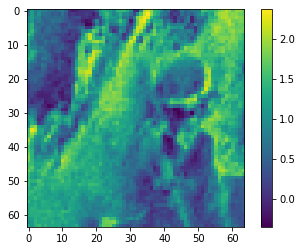

In [ ]:
plt.imshow(patches_train_2022_array[213,:,:,1])
plt.colorbar()
plt.show()


In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_3_2022_v2.npy', patches_test_2022_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_3_2022_v2.npy', patches_train_2022_array)

# Patches 64x64 with max depth 20m. Area 4

## Patches 2019

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2019 = []
patches_train_2019 = []


root_dir = '/content/drive/MyDrive/GEE_good_2019/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 4
      print('\n image 4:')
      image_no_4 = np.copy(image)
      image_no_4[2000:,2800:,:] = np.nan
      image_4 = image[2000:,2800:,:]

      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_4, image_4, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2019.append(zeroed_patches_test)
      patches_train_2019.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2018-12-19
shape:  5507532

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1524, 64, 64, 13)
(1524, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(589, 64, 64, 13)
(589, 64, 64, 13)
2019-01-03
shape:  5757403

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1493, 64, 64, 13)
(1493, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(589, 64, 64, 13)
(589, 64, 64, 13)
2019-01-08
shape:  5776356

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1575, 64, 64, 13)
(1575, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(585, 64, 64, 13)
(585, 64, 64, 13)
2019-01-13
shape:  5688645

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1570, 64, 64, 13)
(1570, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(584, 64, 64, 13)
(584, 64, 64, 13)
2019-02-02
shape:  5723961

 image 4:
Number of patc

In [ ]:
patches_test_2019_array = np.concatenate(patches_test_2019, axis=0)
patches_test_2019_array.shape
# With no random starting point and no 10% striding: 5100 patches.

(8794, 64, 64, 13)

In [ ]:
patches_train_2019_array = np.concatenate(patches_train_2019, axis=0)
patches_train_2019_array.shape
# With no random starting point and no 10% striding: 20081 patches.

(23034, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_4_2019_v2.npy', patches_test_2019_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_4_2019_v2.npy', patches_train_2019_array)

## Patches 2020

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2020 = []
patches_train_2020 = []


root_dir = '/content/drive/MyDrive/GEE_good_2020/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 4
      print('\n image 4:')
      image_no_4 = np.copy(image)
      image_no_4[2000:,2800:,:] = np.nan
      image_4 = image[2000:,2800:,:]

      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_4, image_4, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2020.append(zeroed_patches_test)
      patches_train_2020.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2020-02-02
shape:  5769434

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1581, 64, 64, 13)
(1581, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(588, 64, 64, 13)
(588, 64, 64, 13)
2020-02-12
shape:  5496404

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1542, 64, 64, 13)
(1542, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(617, 64, 64, 13)
(617, 64, 64, 13)
2020-02-17
shape:  5762866

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1483, 64, 64, 13)
(1483, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(587, 64, 64, 13)
(587, 64, 64, 13)
2020-03-13
shape:  5607266

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1545, 64, 64, 13)
(1545, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(590, 64, 64, 13)
(590, 64, 64, 13)
2020-10-09
shape:  5690770

 image 4:
Number of patc

In [ ]:
patches_test_2020_array = np.concatenate(patches_test_2020, axis=0)
patches_test_2020_array.shape

(6505, 64, 64, 13)

In [ ]:
patches_train_2020_array = np.concatenate(patches_train_2020, axis=0)
patches_train_2020_array.shape
# With no random starting point and no 10% striding: 14797 patches.

(16842, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_4_2020_v2.npy', patches_test_2020_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_4_2020_v2.npy', patches_train_2020_array)

## Patches 2021

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2021 = []
patches_train_2021 = []


root_dir = '/content/drive/MyDrive/GEE_good_2021/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 4
      print('\n image 4:')
      image_no_4 = np.copy(image)
      image_no_4[2000:,2800:,:] = np.nan
      image_4 = image[2000:,2800:,:]

      # Extract patches
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_4, image_4, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2021.append(zeroed_patches_test)
      patches_train_2021.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2021-01-07
shape:  5773538

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1496, 64, 64, 13)
(1496, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(589, 64, 64, 13)
(589, 64, 64, 13)
2021-01-12
shape:  5772530

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1575, 64, 64, 13)
(1575, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(588, 64, 64, 13)
(588, 64, 64, 13)
2021-01-17
shape:  5641571

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1581, 64, 64, 13)
(1581, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(585, 64, 64, 13)
(585, 64, 64, 13)
2021-01-22
shape:  5776372

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1576, 64, 64, 13)
(1576, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(584, 64, 64, 13)
(584, 64, 64, 13)
2021-01-27
shape:  5777107

 image 4:
Number of patc

In [ ]:
patches_test_2021_array = np.concatenate(patches_test_2021, axis=0)
patches_test_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.

(8206, 64, 64, 13)

In [ ]:
patches_train_2021_array = np.concatenate(patches_train_2021, axis=0)
patches_train_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.
# With random patching, no norm: 23056 patches.

(21820, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_4_2021_v2.npy', patches_test_2021_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_4_2021_v2.npy', patches_train_2021_array)

## Patches 2022

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2022 = []
patches_train_2022 = []


root_dir = '/content/drive/MyDrive/GEE_good_2022/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = clean_image(image)
      image = normalize_image(image)

      ### IMAGE 4
      print('\n image 4:')
      image_no_4 = np.copy(image)
      image_no_4[2000:,2800:,:] = np.nan
      image_4 = image[2000:,2800:,:]
      # Extract patches
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_4, image_4, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2022.append(zeroed_patches_test)
      patches_train_2022.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2022-01-12
shape:  5776609

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1582, 64, 64, 13)
(1582, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(588, 64, 64, 13)
(588, 64, 64, 13)
2022-01-22
shape:  5657143

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1577, 64, 64, 13)
(1577, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(558, 64, 64, 13)
(558, 64, 64, 13)
2022-02-21
shape:  3293632

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1243, 64, 64, 13)
(1243, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(580, 64, 64, 13)
(580, 64, 64, 13)
2022-03-03
shape:  1391391

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(687, 64, 64, 13)
(687, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(94, 64, 64, 13)
(94, 64, 64, 13)
2022-11-03
shape:  3021039

 image 4:
Number of patches 

In [ ]:
patches_test_2022_array = np.concatenate(patches_test_2022, axis=0)
patches_test_2022_array.shape
# With no random starting point and no 10% striding: 2729 patches.

(4695, 64, 64, 13)

In [ ]:
patches_train_2022_array = np.concatenate(patches_train_2022, axis=0)
patches_train_2022_array.shape
# With no random starting point and no 10% striding: 10335 patches.

(11403, 64, 64, 13)

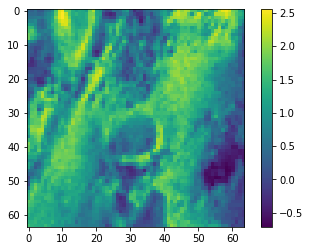

In [ ]:
plt.imshow(patches_train_2022_array[213,:,:,1])
plt.colorbar()
plt.show()


In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_4_2022_v2.npy', patches_test_2022_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_4_2022_v2.npy', patches_train_2022_array)

# Patches 64x64 no max depth. Area 1

## Patches 2019

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2019 = []
patches_train_2019 = []


root_dir = '/content/drive/MyDrive/GEE_good_2019/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 1
      # Select training area:
      image_no_1 = np.copy(image)
      # Set pixels in specified slice to NaN
      image_no_1[70:1035,:, :] = np.nan
      # Train set
      image_1 = image[70:1035,:, :]
      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_1, image_1, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2019.append(zeroed_patches_test)
      patches_train_2019.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2018-12-19
shape:  8470650
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2142, 64, 64, 13)
(2142, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(673, 64, 64, 13)
(673, 64, 64, 13)
2019-01-03
shape:  8733907
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2172, 64, 64, 13)
(2172, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(668, 64, 64, 13)
(668, 64, 64, 13)
2019-01-08
shape:  8755489
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2180, 64, 64, 13)
(2180, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(670, 64, 64, 13)
(670, 64, 64, 13)
2019-01-13
shape:  8666044
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2184, 64, 64, 13)
(2184, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(674, 64, 64, 13)
(674, 64, 64, 13)
2019-02-02
shape:  8563505
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2078,

In [ ]:
patches_test_2019_array = np.concatenate(patches_test_2019, axis=0)
patches_test_2019_array.shape
# With no random starting point and no 10% striding: 5100 patches.

(10176, 64, 64, 13)

In [ ]:
patches_train_2019_array = np.concatenate(patches_train_2019, axis=0)
patches_train_2019_array.shape
# With no random starting point and no 10% striding: 20081 patches.

(32049, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_1_2019_no_max_v2.npy', patches_test_2019_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_1_2019_no_max_v2.npy', patches_train_2019_array)

## Patches 2020

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2020 = []
patches_train_2020 = []


root_dir = '/content/drive/MyDrive/GEE_good_2020/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 1
      # Select training area:
      image_no_1 = np.copy(image)
      # Set pixels in specified slice to NaN
      image_no_1[70:1035,:, :] = np.nan
      # Train set
      image_1 = image[70:1035,:, :]
      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_1, image_1, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2020.append(zeroed_patches_test)
      patches_train_2020.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2020-02-02
shape:  8735227
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2174, 64, 64, 13)
(2174, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(691, 64, 64, 13)
(691, 64, 64, 13)
2020-02-12
shape:  8468763
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2078, 64, 64, 13)
(2078, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(656, 64, 64, 13)
(656, 64, 64, 13)
2020-02-17
shape:  8741922
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2181, 64, 64, 13)
(2181, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(683, 64, 64, 13)
(683, 64, 64, 13)
2020-03-13
shape:  8585116
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2152, 64, 64, 13)
(2152, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(672, 64, 64, 13)
(672, 64, 64, 13)
2020-10-09
shape:  8669689
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2178,

In [ ]:
patches_test_2020_array = np.concatenate(patches_test_2020, axis=0)
patches_test_2020_array.shape

(7488, 64, 64, 13)

In [ ]:
patches_train_2020_array = np.concatenate(patches_train_2020, axis=0)
patches_train_2020_array.shape
# With no random starting point and no 10% striding: 14797 patches.

(23833, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_1_2020_no_max_v2.npy', patches_test_2020_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_1_2020_no_max_v2.npy', patches_train_2020_array)

## Patches 2021

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2021 = []
patches_train_2021 = []


root_dir = '/content/drive/MyDrive/GEE_good_2021/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 1
      # Select training area:
      image_no_1 = np.copy(image)
      # Set pixels in specified slice to NaN
      image_no_1[70:1035,:, :] = np.nan
      # Train set
      image_1 = image[70:1035,:, :]
      # Extract patches
      patch_size = (16, 16, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_1, image_1, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2021.append(zeroed_patches_test)
      patches_train_2021.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2021-01-07
shape:  8752528
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2186, 64, 64, 13)
(2186, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(684, 64, 64, 13)
(684, 64, 64, 13)
2021-01-12
shape:  8751697
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2176, 64, 64, 13)
(2176, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(685, 64, 64, 13)
(685, 64, 64, 13)
2021-01-17
shape:  8591704
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2170, 64, 64, 13)
(2170, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(678, 64, 64, 13)
(678, 64, 64, 13)
2021-01-22
shape:  8755515
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2177, 64, 64, 13)
(2177, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(683, 64, 64, 13)
(683, 64, 64, 13)
2021-01-27
shape:  8756195
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2092,

In [ ]:
patches_test_2021_array = np.concatenate(patches_test_2021, axis=0)
patches_test_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.

(9579, 64, 64, 13)

In [ ]:
patches_train_2021_array = np.concatenate(patches_train_2021, axis=0)
patches_train_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.
# With random patching, no norm: 23056 patches.

(30090, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_1_2021_no_max_v2.npy', patches_test_2021_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_1_2021_no_max_v2.npy', patches_train_2021_array)

## Patches 2022

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2022 = []
patches_train_2022 = []


root_dir = '/content/drive/MyDrive/GEE_good_2022/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 1
      # Select training area:
      image_no_1 = np.copy(image)
      # Set pixels in specified slice to NaN
      image_no_1[70:1035,:, :] = np.nan
      # Train set
      image_1 = image[70:1035,:, :]
      # Extract patches
      patch_size = (16, 16, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_1, image_1, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2022.append(zeroed_patches_test)
      patches_train_2022.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2022-01-12
shape:  8755689
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2187, 64, 64, 13)
(2187, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(669, 64, 64, 13)
(669, 64, 64, 13)
2022-01-22
shape:  8608291
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2151, 64, 64, 13)
(2151, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(683, 64, 64, 13)
(683, 64, 64, 13)
2022-02-21
shape:  4885104
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1797, 64, 64, 13)
(1797, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(599, 64, 64, 13)
(599, 64, 64, 13)
2022-03-03
shape:  2602686
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(533, 64, 64, 13)
(533, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(660, 64, 64, 13)
(660, 64, 64, 13)
2022-11-03
shape:  3826058
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1647, 6

In [ ]:
patches_test_2022_array = np.concatenate(patches_test_2022, axis=0)
patches_test_2022_array.shape
# With no random starting point and no 10% striding: 2729 patches.

(4745, 64, 64, 13)

In [ ]:
patches_train_2022_array = np.concatenate(patches_train_2022, axis=0)
patches_train_2022_array.shape
# With no random starting point and no 10% striding: 10335 patches.

(16787, 64, 64, 13)

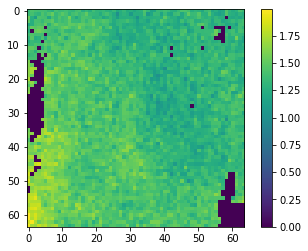

In [ ]:
plt.imshow(patches_train_2022_array[213,:,:,1])
plt.colorbar()
plt.show()


In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_1_2022_no_max_v2.npy', patches_test_2022_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_1_2022_no_max_v2.npy', patches_train_2022_array)

# Patches 64x64 no max depth. Area 2

## Patches 2019

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2019 = []
patches_train_2019 = []


root_dir = '/content/drive/MyDrive/GEE_good_2019/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 2
      print('\n image 2:')
      image_no_2 = np.copy(image)
      image_no_2[1035:2000,:,:] = np.nan
      image_2 = image[1035:2000,:,:]

      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_2, image_2, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2019.append(zeroed_patches_test)
      patches_train_2019.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2018-12-19
shape:  8470650

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2080, 64, 64, 13)
(2080, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(635, 64, 64, 13)
(635, 64, 64, 13)
2019-01-03
shape:  8733907

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2231, 64, 64, 13)
(2231, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(666, 64, 64, 13)
(666, 64, 64, 13)
2019-01-08
shape:  8755489

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2185, 64, 64, 13)
(2185, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(660, 64, 64, 13)
(660, 64, 64, 13)
2019-01-13
shape:  8666044

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2090, 64, 64, 13)
(2090, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(661, 64, 64, 13)
(661, 64, 64, 13)
2019-02-02
shape:  8563505

 image 2:
Number of patc

In [ ]:
patches_test_2019_array = np.concatenate(patches_test_2019, axis=0)
patches_test_2019_array.shape
# With no random starting point and no 10% striding: 5100 patches.

(9844, 64, 64, 13)

In [ ]:
patches_train_2019_array = np.concatenate(patches_train_2019, axis=0)
patches_train_2019_array.shape
# With no random starting point and no 10% striding: 20081 patches.

(32311, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_2_2019_no_max_v2.npy', patches_test_2019_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_2_2019_no_max_v2.npy', patches_train_2019_array)

## Patches 2020

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2020 = []
patches_train_2020 = []


root_dir = '/content/drive/MyDrive/GEE_good_2020/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 2
      print('\n image 2:')
      image_no_2 = np.copy(image)
      image_no_2[1035:2000,:,:] = np.nan
      image_2 = image[1035:2000,:,:]
      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_2, image_2, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2020.append(zeroed_patches_test)
      patches_train_2020.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2020-02-02
shape:  8735227

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2189, 64, 64, 13)
(2189, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(661, 64, 64, 13)
(661, 64, 64, 13)
2020-02-12
shape:  8468763

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2051, 64, 64, 13)
(2051, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(713, 64, 64, 13)
(713, 64, 64, 13)
2020-02-17
shape:  8741922

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2189, 64, 64, 13)
(2189, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(663, 64, 64, 13)
(663, 64, 64, 13)
2020-03-13
shape:  8585116

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2180, 64, 64, 13)
(2180, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(638, 64, 64, 13)
(638, 64, 64, 13)
2020-10-09
shape:  8669689

 image 2:
Number of patc

In [ ]:
patches_test_2020_array = np.concatenate(patches_test_2020, axis=0)
patches_test_2020_array.shape

(7308, 64, 64, 13)

In [ ]:
patches_train_2020_array = np.concatenate(patches_train_2020, axis=0)
patches_train_2020_array.shape
# With no random starting point and no 10% striding: 14797 patches.

(23811, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_2_2020_no_max_v2.npy', patches_test_2020_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_2_2020_no_max_v2.npy', patches_train_2020_array)

## Patches 2021

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2021 = []
patches_train_2021 = []


root_dir = '/content/drive/MyDrive/GEE_good_2021/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 2
      print('\n image 2:')
      image_no_2 = np.copy(image)
      image_no_2[1035:2000,:,:] = np.nan
      image_2 = image[1035:2000,:,:]
      # Extract patches
      patch_size = (16, 16, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_2, image_2, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2021.append(zeroed_patches_test)
      patches_train_2021.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2021-01-07
shape:  8752528

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2231, 64, 64, 13)
(2231, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(662, 64, 64, 13)
(662, 64, 64, 13)
2021-01-12
shape:  8751697

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2187, 64, 64, 13)
(2187, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(661, 64, 64, 13)
(661, 64, 64, 13)
2021-01-17
shape:  8591704

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2225, 64, 64, 13)
(2225, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(656, 64, 64, 13)
(656, 64, 64, 13)
2021-01-22
shape:  8755515

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2090, 64, 64, 13)
(2090, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(662, 64, 64, 13)
(662, 64, 64, 13)
2021-01-27
shape:  8756195

 image 2:
Number of patc

In [ ]:
patches_test_2021_array = np.concatenate(patches_test_2021, axis=0)
patches_test_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.

(9285, 64, 64, 13)

In [ ]:
patches_train_2021_array = np.concatenate(patches_train_2021, axis=0)
patches_train_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.
# With random patching, no norm: 23056 patches.

(30579, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_2_2021_no_max_v2.npy', patches_test_2021_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_2_2021_no_max_v2.npy', patches_train_2021_array)

## Patches 2022

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2022 = []
patches_train_2022 = []


root_dir = '/content/drive/MyDrive/GEE_good_2022/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 2
      print('\n image 2:')
      image_no_2 = np.copy(image)
      image_no_2[1035:2000,:,:] = np.nan
      image_2 = image[1035:2000,:,:]
      # Extract patches
      patch_size = (16, 16, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_2, image_2, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2022.append(zeroed_patches_test)
      patches_train_2022.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2022-01-12
shape:  8755689

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2189, 64, 64, 13)
(2189, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(712, 64, 64, 13)
(712, 64, 64, 13)
2022-01-22
shape:  8608291

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2067, 64, 64, 13)
(2067, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(661, 64, 64, 13)
(661, 64, 64, 13)
2022-02-21
shape:  4885104

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1915, 64, 64, 13)
(1915, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(553, 64, 64, 13)
(553, 64, 64, 13)
2022-03-03
shape:  2602686

 image 2:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(948, 64, 64, 13)
(948, 64, 64, 13)
Number of patches for testing: 1472
Patch shape: (64, 64, 13)
(234, 64, 64, 13)
(234, 64, 64, 13)
2022-11-03
shape:  3826058

 image 2:
Number of patche

In [ ]:
patches_test_2022_array = np.concatenate(patches_test_2022, axis=0)
patches_test_2022_array.shape
# With no random starting point and no 10% striding: 2729 patches.

(4726, 64, 64, 13)

In [ ]:
patches_train_2022_array = np.concatenate(patches_train_2022, axis=0)
patches_train_2022_array.shape
# With no random starting point and no 10% striding: 10335 patches.

(16675, 64, 64, 13)

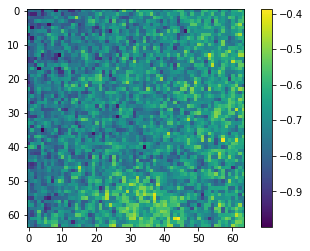

In [ ]:
plt.imshow(patches_train_2022_array[213,:,:,1])
plt.colorbar()
plt.show()


In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_2_2022_no_max_v2.npy', patches_test_2022_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_2_2022_no_max_v2.npy', patches_train_2022_array)

# Patches 64x64 no max depth. Area 3

## Patches 2019

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2019 = []
patches_train_2019 = []


root_dir = '/content/drive/MyDrive/GEE_good_2019/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 3
      print('\n image 3:')
      image_no_3 = np.copy(image)
      image_no_3[2000:,:2800,:] = np.nan
      image_3 = image[2000:,:2800,:]

      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_3, image_3, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2019.append(zeroed_patches_test)
      patches_train_2019.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2018-12-19
shape:  8470650

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2145, 64, 64, 13)
(2145, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(670, 64, 64, 13)
(670, 64, 64, 13)
2019-01-03
shape:  8733907

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2207, 64, 64, 13)
(2207, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(678, 64, 64, 13)
(678, 64, 64, 13)
2019-01-08
shape:  8755489

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2208, 64, 64, 13)
(2208, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(647, 64, 64, 13)
(647, 64, 64, 13)
2019-01-13
shape:  8666044

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2105, 64, 64, 13)
(2105, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(684, 64, 64, 13)
(684, 64, 64, 13)
2019-02-02
shape:  8563505

 image 3:
Number of patc

In [ ]:
patches_test_2019_array = np.concatenate(patches_test_2019, axis=0)
patches_test_2019_array.shape
# With no random starting point and no 10% striding: 5100 patches.

(10114, 64, 64, 13)

In [ ]:
patches_train_2019_array = np.concatenate(patches_train_2019, axis=0)
patches_train_2019_array.shape
# With no random starting point and no 10% striding: 20081 patches.

(32138, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_3_2019_no_max_v2.npy', patches_test_2019_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_3_2019_no_max_v2.npy', patches_train_2019_array)

## Patches 2020

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2020 = []
patches_train_2020 = []


root_dir = '/content/drive/MyDrive/GEE_good_2020/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 3
      print('\n image 3:')
      image_no_3 = np.copy(image)
      image_no_3[2000:,:2800,:] = np.nan
      image_3 = image[2000:,:2800,:]

      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_3, image_3, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2020.append(zeroed_patches_test)
      patches_train_2020.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2020-02-02
shape:  8735227

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2105, 64, 64, 13)
(2105, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(652, 64, 64, 13)
(652, 64, 64, 13)
2020-02-12
shape:  8468763

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2087, 64, 64, 13)
(2087, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(679, 64, 64, 13)
(679, 64, 64, 13)
2020-02-17
shape:  8741922

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2202, 64, 64, 13)
(2202, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(680, 64, 64, 13)
(680, 64, 64, 13)
2020-03-13
shape:  8585116

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2179, 64, 64, 13)
(2179, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(653, 64, 64, 13)
(653, 64, 64, 13)
2020-10-09
shape:  8669689

 image 3:
Number of patc

In [ ]:
patches_test_2020_array = np.concatenate(patches_test_2020, axis=0)
patches_test_2020_array.shape

(7414, 64, 64, 13)

In [ ]:
patches_train_2020_array = np.concatenate(patches_train_2020, axis=0)
patches_train_2020_array.shape
# With no random starting point and no 10% striding: 14797 patches.

(23972, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_3_2020_no_max_v2.npy', patches_test_2020_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_3_2020_no_max_v2.npy', patches_train_2020_array)

## Patches 2021

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2021 = []
patches_train_2021 = []


root_dir = '/content/drive/MyDrive/GEE_good_2021/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 3
      print('\n image 3:')
      image_no_3 = np.copy(image)
      image_no_3[2000:,:2800,:] = np.nan
      image_3 = image[2000:,:2800,:]

      # Extract patches
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_3, image_3, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2021.append(zeroed_patches_test)
      patches_train_2021.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2021-01-07
shape:  8752528

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2191, 64, 64, 13)
(2191, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(680, 64, 64, 13)
(680, 64, 64, 13)
2021-01-12
shape:  8751697

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2113, 64, 64, 13)
(2113, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(692, 64, 64, 13)
(692, 64, 64, 13)
2021-01-17
shape:  8591704

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2178, 64, 64, 13)
(2178, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(669, 64, 64, 13)
(669, 64, 64, 13)
2021-01-22
shape:  8755515

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2179, 64, 64, 13)
(2179, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(672, 64, 64, 13)
(672, 64, 64, 13)
2021-01-27
shape:  8756195

 image 3:
Number of patc

In [ ]:
patches_test_2021_array = np.concatenate(patches_test_2021, axis=0)
patches_test_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.

(9388, 64, 64, 13)

In [ ]:
patches_train_2021_array = np.concatenate(patches_train_2021, axis=0)
patches_train_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.
# With random patching, no norm: 23056 patches.

(30522, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_3_2021_no_max_v2.npy', patches_test_2021_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_3_2021_no_max_v2.npy', patches_train_2021_array)

## Patches 2022

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2022 = []
patches_train_2022 = []


root_dir = '/content/drive/MyDrive/GEE_good_2022/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 3
      print('\n image 3:')
      image_no_3 = np.copy(image)
      image_no_3[2000:,:2800,:] = np.nan
      image_3 = image[2000:,:2800,:]

      # Extract patches
      patch_size = (16, 16, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_3, image_3, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2022.append(zeroed_patches_test)
      patches_train_2022.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2022-01-12
shape:  8755689

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2196, 64, 64, 13)
(2196, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(671, 64, 64, 13)
(671, 64, 64, 13)
2022-01-22
shape:  8608291

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2159, 64, 64, 13)
(2159, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(668, 64, 64, 13)
(668, 64, 64, 13)
2022-02-21
shape:  4885104

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1981, 64, 64, 13)
(1981, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(533, 64, 64, 13)
(533, 64, 64, 13)
2022-03-03
shape:  2602686

 image 3:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1105, 64, 64, 13)
(1105, 64, 64, 13)
Number of patches for testing: 1440
Patch shape: (64, 64, 13)
(100, 64, 64, 13)
(100, 64, 64, 13)
2022-11-03
shape:  3826058

 image 3:
Number of patc

In [ ]:
patches_test_2022_array = np.concatenate(patches_test_2022, axis=0)
patches_test_2022_array.shape
# With no random starting point and no 10% striding: 2729 patches.

(5280, 64, 64, 13)

In [ ]:
patches_train_2022_array = np.concatenate(patches_train_2022, axis=0)
patches_train_2022_array.shape
# With no random starting point and no 10% striding: 10335 patches.

(16318, 64, 64, 13)

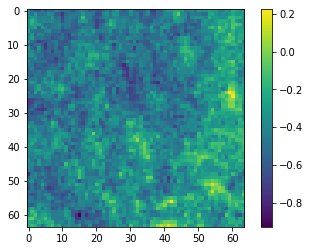

In [ ]:
plt.imshow(patches_train_2022_array[213,:,:,1])
plt.colorbar()
plt.show()


In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_3_2022_no_max_v2.npy', patches_test_2022_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_3_2022_no_max_v2.npy', patches_train_2022_array)

# Patches 64x64 no max depth. Area 4

## Patches 2019

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2019 = []
patches_train_2019 = []


root_dir = '/content/drive/MyDrive/GEE_good_2019/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 4
      print('\n image 4:')
      image_no_4 = np.copy(image)
      image_no_4[2000:,2800:,:] = np.nan
      image_4 = image[2000:,2800:,:]

      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_4, image_4, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2019.append(zeroed_patches_test)
      patches_train_2019.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2018-12-19
shape:  8470650

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2132, 64, 64, 13)
(2132, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(680, 64, 64, 13)
(680, 64, 64, 13)
2019-01-03
shape:  8733907

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2158, 64, 64, 13)
(2158, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(681, 64, 64, 13)
(681, 64, 64, 13)
2019-01-08
shape:  8755489

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2165, 64, 64, 13)
(2165, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(683, 64, 64, 13)
(683, 64, 64, 13)
2019-01-13
shape:  8666044

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2152, 64, 64, 13)
(2152, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(681, 64, 64, 13)
(681, 64, 64, 13)
2019-02-02
shape:  8563505

 image 4:
Number of patc

In [ ]:
patches_test_2019_array = np.concatenate(patches_test_2019, axis=0)
patches_test_2019_array.shape
# With no random starting point and no 10% striding: 5100 patches.

(10249, 64, 64, 13)

In [ ]:
patches_train_2019_array = np.concatenate(patches_train_2019, axis=0)
patches_train_2019_array.shape
# With no random starting point and no 10% striding: 20081 patches.

(31700, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_4_2019_no_max_v2.npy', patches_test_2019_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_4_2019_no_max_v2.npy', patches_train_2019_array)

## Patches 2020

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2020 = []
patches_train_2020 = []


root_dir = '/content/drive/MyDrive/GEE_good_2020/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 4
      print('\n image 4:')
      image_no_4 = np.copy(image)
      image_no_4[2000:,2800:,:] = np.nan
      image_4 = image[2000:,2800:,:]

      # Extract patches
      patch_size = (64, 64, 13)
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_4, image_4, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2020.append(zeroed_patches_test)
      patches_train_2020.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2020-02-02
shape:  8735227

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2160, 64, 64, 13)
(2160, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(685, 64, 64, 13)
(685, 64, 64, 13)
2020-02-12
shape:  8468763

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2124, 64, 64, 13)
(2124, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(686, 64, 64, 13)
(686, 64, 64, 13)
2020-02-17
shape:  8741922

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2167, 64, 64, 13)
(2167, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(692, 64, 64, 13)
(692, 64, 64, 13)
2020-03-13
shape:  8585116

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2130, 64, 64, 13)
(2130, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(711, 64, 64, 13)
(711, 64, 64, 13)
2020-10-09
shape:  8669689

 image 4:
Number of patc

In [ ]:
patches_test_2020_array = np.concatenate(patches_test_2020, axis=0)
patches_test_2020_array.shape

(7598, 64, 64, 13)

In [ ]:
patches_train_2020_array = np.concatenate(patches_train_2020, axis=0)
patches_train_2020_array.shape
# With no random starting point and no 10% striding: 14797 patches.

(23411, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_4_2020_no_max_v2.npy', patches_test_2020_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_4_2020_no_max_v2.npy', patches_train_2020_array)

## Patches 2021

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2021 = []
patches_train_2021 = []


root_dir = '/content/drive/MyDrive/GEE_good_2021/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 4
      print('\n image 4:')
      image_no_4 = np.copy(image)
      image_no_4[2000:,2800:,:] = np.nan
      image_4 = image[2000:,2800:,:]

      # Extract patches
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_4, image_4, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2021.append(zeroed_patches_test)
      patches_train_2021.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2021-01-07
shape:  8752528

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2166, 64, 64, 13)
(2166, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(688, 64, 64, 13)
(688, 64, 64, 13)
2021-01-12
shape:  8751697

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2080, 64, 64, 13)
(2080, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(690, 64, 64, 13)
(690, 64, 64, 13)
2021-01-17
shape:  8591704

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2149, 64, 64, 13)
(2149, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(688, 64, 64, 13)
(688, 64, 64, 13)
2021-01-22
shape:  8755515

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2172, 64, 64, 13)
(2172, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(687, 64, 64, 13)
(687, 64, 64, 13)
2021-01-27
shape:  8756195

 image 4:
Number of patc

In [ ]:
patches_test_2021_array = np.concatenate(patches_test_2021, axis=0)
patches_test_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.

(9643, 64, 64, 13)

In [ ]:
patches_train_2021_array = np.concatenate(patches_train_2021, axis=0)
patches_train_2021_array.shape
# With no random starting point and no 10% striding: 18837 patches.
# With random patching, no norm: 23056 patches.

(29796, 64, 64, 13)

In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_4_2021_no_max_v2.npy', patches_test_2021_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_4_2021_no_max_v2.npy', patches_train_2021_array)

## Patches 2022

In [ ]:
from pathlib import Path # for reincursive folders
import gc
import matplotlib.colors as mcolors

from google.colab import files

patches_test_2022 = []
patches_train_2022 = []


root_dir = '/content/drive/MyDrive/GEE_good_2022/'

for filename in Path(root_dir).rglob('*.tif'):
  try:
      filename = str(filename)
      date = filename[37:47] # select date of image
      with rasterio.open(filename) as src:
          image = src.read()
      del src
      gc.collect()
      print(date)
      image = stack_layers(image,ref,reference) # Remove NaN values and stack reference data
      image = remove_nan(image) # Remove NaN values and stack reference data
      image_reference = image[12,:,:]
      image = np.transpose(image, (1, 2, 0))
      image = normalize_image(image)

      ### IMAGE 4
      print('\n image 4:')
      image_no_4 = np.copy(image)
      image_no_4[2000:,2800:,:] = np.nan
      image_4 = image[2000:,2800:,:]
      # Extract patches
      stride = 58
      zeroed_patches_train, zeroed_patches_test, removed_indices = extract_zeroed_patches(image_no_4, image_4, patch_size=(64, 64, 13), nan_threshold=0.9)

      # append patches
      patches_test_2022.append(zeroed_patches_test)
      patches_train_2022.append(zeroed_patches_train)

  except Exception as e:
    # code to handle the exception
    print(e)
    pass

2022-01-12
shape:  8755689

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2066, 64, 64, 13)
(2066, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(683, 64, 64, 13)
(683, 64, 64, 13)
2022-01-22
shape:  8608291

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(2160, 64, 64, 13)
(2160, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(658, 64, 64, 13)
(658, 64, 64, 13)
2022-02-21
shape:  4885104

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1725, 64, 64, 13)
(1725, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(673, 64, 64, 13)
(673, 64, 64, 13)
2022-03-03
shape:  2602686

 image 4:
Number of patches for training: 5980
Patch shape: (64, 64, 13)
(1077, 64, 64, 13)
(1077, 64, 64, 13)
Number of patches for testing: 1320
Patch shape: (64, 64, 13)
(97, 64, 64, 13)
(97, 64, 64, 13)
2022-11-03
shape:  3826058

 image 4:
Number of patche

In [ ]:
patches_test_2022_array = np.concatenate(patches_test_2022, axis=0)
patches_test_2022_array.shape
# With no random starting point and no 10% striding: 2729 patches.

(5521, 64, 64, 13)

In [ ]:
patches_train_2022_array = np.concatenate(patches_train_2022, axis=0)
patches_train_2022_array.shape
# With no random starting point and no 10% striding: 10335 patches.

(15834, 64, 64, 13)

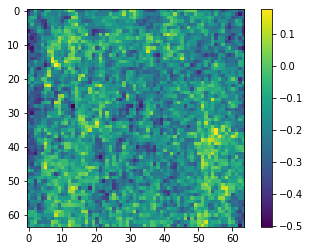

In [ ]:
plt.imshow(patches_train_2022_array[213,:,:,1])
plt.colorbar()
plt.show()


In [ ]:
np.save('/content/drive/My Drive/Patches_64_20m/patches_test_4_2022_no_max_v2.npy', patches_test_2022_array)
np.save('/content/drive/My Drive/Patches_64_20m/patches_train_no_4_2022_no_max_v2.npy', patches_train_2022_array)